# Import 

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import silhouette_samples
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, to_tree

from pathlib import Path


In [2]:
from module.data_prep import prep_foodweb_data, prep_recipe_data
from module.fvec import bipartite_cooarray, adjacency_cooarray
from module.null_helpers import rn_RIshuff_wrapper, rn_RCshuff_wrapper, fw_typeshuff_wrapper
from module.graphpeeler import layer_realisation

In [3]:
save_things = True

In [4]:
cwd = Path.cwd()


# Food web:

Calculate the null model for:
1. Coarsest/broadest animal categorisation in `meta_df_filtered`
2. Finest animal categorisation in `meta_fine_df_2_filtered`
3. Topological labelling from layer analysis.

In [5]:
fw_data_dir = cwd.parent / 'data' / 'foodweb'
fw_processed_dir = fw_data_dir / 'processed'

fw_fig_dir = cwd.parent / 'figures' / 'foodweb'


In [6]:
fw_df, meta_df_filtered, meta_fine_df_filtered, meta_fine_df_2_filtered = prep_foodweb_data()

In [7]:
fw_data = {'fw': fw_df, 'meta_f': meta_df_filtered, 'meta_ff': meta_fine_df_filtered, 'meta_fff': meta_fine_df_2_filtered}

vectors = {}
for key in ['f', 'ff', 'fff']: # coarseness of food web animal labelling: more 'f's the finer...
    v = pd.read_parquet(fw_processed_dir / f'{key}_vectors.parquet')
    vectors[f'{key}_vectors'] = v

In [8]:
mode = 'fff' # which level of coarseness in the food web animal labelling to use
fw_meta = fw_data[f'meta_{mode}']
fw_vectors = vectors[f'{mode}_vectors']

unique_types = fw_meta['type'].unique()
in_cols = [i + '_in' for i in unique_types]
out_cols = [i + '_out' for i in unique_types]

In [9]:
# here: broadest and finest level of food web labelling
master_meta_df = meta_df_filtered.join(meta_fine_df_2_filtered.set_index('node'), on='node', rsuffix='_finest')


In [10]:
metric = 'euclidean'
method = 'ward'

ind_to_id = fw_vectors.index.values
# Z = linkage(fw_vectors.fillna(0).iloc[:, :-2], metric=metric, method=method) 

### silhouette scores for finest and coarsest animal types:

In [11]:
# finest type to coarsest type
finest_to_coarse = master_meta_df.drop_duplicates(subset=['type', 'type_finest']).set_index('type_finest')['type'].to_dict()
# finest_to_type = master_meta_df.drop_duplicates(subset=['type', 'type_finest']).set_index('type_finest')['type'].to_dict()
finest_type_array = master_meta_df.set_index('node').loc[ind_to_id].type_finest.tolist() # finest animal type array
silscores = silhouette_samples(fw_vectors, labels=finest_type_array, metric='euclidean')

finest_type_silscore = np.mean(silscores)
print('Silhouette score for correlation with finest animal type and the vector embedding: ', finest_type_silscore)

Silhouette score for correlation with finest animal type and the vector embedding:  -0.12623349253686136


In [12]:
coarse_meta_dict = master_meta_df.set_index('node').type.to_dict() # coarse labelling
coarse_types_unique = master_meta_df.type.unique() # unique coarse labels
ind_to_coarse = [coarse_meta_dict.get(i) for i in ind_to_id] # coarse labels for each index

coarse_to_numeric =dict(zip(coarse_types_unique, [0,0,0,0,0,1,1,1,2,2,2,2,2,3,4,5,5,5,5]))
numeric_meta_dict = dict(zip(master_meta_df.node, master_meta_df.type.apply(coarse_to_numeric.get))) # numeric labels for each animal
coarse_type_array = [numeric_meta_dict.get(i) for i in ind_to_id] # coarse labels for each index

silscores = silhouette_samples(fw_vectors, labels=coarse_type_array, metric='euclidean')
coarse_type_silscore = np.mean(silscores)
print('Silhouette score for correlation with coarsest animal type and the vector embedding: ', coarse_type_silscore)

Silhouette score for correlation with coarsest animal type and the vector embedding:  0.10167806514380784


In [13]:
master_meta_df['numeric'] = master_meta_df['type'].apply(coarse_to_numeric.get)
finest_to_coarse = master_meta_df.drop_duplicates(subset=['type_finest', 'numeric']).set_index('type_finest')['numeric'].to_dict()


## Graph peeler for stratifying the food web


In [14]:

prep_for_peeling = fw_df.copy(True)
prep_for_peeling['weight'] = 1
prep_for_peeling.columns = ['pre', 'post', 'weight']

start_ids = list(set(prep_for_peeling.pre.unique()) - set(prep_for_peeling.post.unique()))

postId = prep_for_peeling['post'].values
preId = prep_for_peeling['pre'].values
in_strengths = prep_for_peeling.groupby('post').weight.sum().to_dict()
out_strengths = prep_for_peeling.groupby('pre').weight.sum().to_dict()

weights = prep_for_peeling['weight'].values

# weight of edges as a proportion of their strength:
prep_for_peeling['in_prop_weight'] = [weights[i]/in_strengths.get(postId[i]) for i in range(len(prep_for_peeling))] 
prep_for_peeling['out_prop_weight'] = [weights[i]/out_strengths.get(preId[i]) for i in range(len(prep_for_peeling))]

# out-strength as a proportion of the total in and out strength:
out_strength_prop = {i : out_strengths.get(i, 0)/(in_strengths.get(i, 0) + out_strengths.get(i, 0)) for i in ind_to_id}

prep_for_peeling['in_div_out_prop_weight'] = [weights[i]*out_strength_prop[postId[i]]/in_strengths.get(postId[i]) for i in range(len(prep_for_peeling))]

postId = prep_for_peeling['post'].values
preId = prep_for_peeling['pre'].values
in_strengths = prep_for_peeling.groupby('post').weight.sum().to_dict()
out_strengths = prep_for_peeling.groupby('pre').weight.sum().to_dict()

weights = prep_for_peeling['weight'].values

# weight of edges as a proportion of their strength:
prep_for_peeling['in_prop_weight'] = [weights[i]/in_strengths.get(postId[i]) for i in range(len(prep_for_peeling))] 
prep_for_peeling['out_prop_weight'] = [weights[i]/out_strengths.get(preId[i]) for i in range(len(prep_for_peeling))]

# out-strength as a proportion of the total in and out strength:
out_strength_prop = {i : out_strengths.get(i, 0)/(in_strengths.get(i, 0) + out_strengths.get(i, 0)) for i in ind_to_id}

In [15]:
N=1000
d_layers = []
for i in range(N): 
    nth_r = layer_realisation(df=prep_for_peeling,
                              start_ids=start_ids,
                              correction=1, 
                              N=np.inf, 
                              seed=i, 
                              prepost='pre', 
                              prop_weight='in_prop_weight')
    id_to_layer = {}
    for key, val in nth_r.items():
        for id in val:
            id_to_layer[id] = key
    d_layers.append(pd.Series(id_to_layer, name=f'r_{i}'))

d_layer_df = pd.concat(d_layers, axis=1)
d_colname = f'm_ds_layer'
d_layer_df[d_colname] = d_layer_df.mean(axis=1).sort_values()#.round(0).astype(int) # take the mean layer across all the runs
d_layer_df.index.names=['id']
d_layer_df = d_layer_df[[d_colname]]

### topological layer silhouette score

In [16]:
test_df = fw_vectors #all_ff_vectors.iloc[:,:-2].fillna(0)

layer_dict = d_layer_df[d_colname].round().astype(int).to_dict()
# layer_dict = ((d_layer_df['m_ds_layer'] * 2).round() / 2).astype(int).to_dict() # stratify network into layers of multiple 0.5

animal_layer_array = [str(layer_dict.get(i)) for i in ind_to_id]
# animal_type_array = fw_label_meta.set_index('node').loc[ind_to_id].type.tolist()
# numeric_type_array = [str(numeric_meta_dict.get(i)) for i in ind_to_id]

# combined_arr = [animal_layer_array[i] + '_' + str(coarse_type_array[i]) for i in range(len(ind_to_id))] # combination of labels...

test_arr = animal_layer_array # coarse_type_array

# animal_type_array = meta_finest_df.set_index('id').loc[ind_to_id].type.tolist()
silscores = silhouette_samples(test_df.loc[ind_to_id], labels=test_arr, metric='euclidean')

layer_test_silscore = np.mean(silscores)

In [17]:
# d_layer_df['round_layer'] = (d_layer_df['m_ds_layer'] * 2).round() / 2
# d_layer_df['round_layer'] = d_layer_df['m_ds_layer'].round()

In [18]:

print('Silhouette score for correlation with topological layer and the vector embedding in food web: ', layer_test_silscore)

Silhouette score for correlation with topological layer and the vector embedding in food web:  0.1166300174249245


In [19]:
a_AA_coo, _ = adjacency_cooarray(df=fw_df, row_col=['prey', 'predator'], id_order=ind_to_id, weight=False, directed=True)


In [21]:
seeds = np.arange(1000)
# toconcat = []
coarse_null_silscores = []
layer_null_silscores = []
finest_null_silscores = []
for seed in seeds:
    shuff_all_norm_vec_df, meta_finest_shuff = fw_typeshuff_wrapper(seed, fw_meta, ind_to_id, a_AA_coo)

    # shuff_animal_type_array = meta_finest_shuff['node'].apply(lambda x: numeric_meta_dict[x]).values # this is identity preserving numeric type array
    shuff_animal_type_array = meta_finest_shuff['type'].apply(lambda x: finest_to_coarse[x]).values # this is identity consistent numeric type array
    shuff_finest_type_array = meta_finest_shuff.set_index('node').loc[ind_to_id].type.tolist() # finest animal type array

    coarse_shuff_silscores = silhouette_samples(shuff_all_norm_vec_df.loc[ind_to_id].fillna(0), labels=shuff_animal_type_array, metric='euclidean')
    finest_shuff_silscores = silhouette_samples(shuff_all_norm_vec_df.loc[ind_to_id].fillna(0), labels=shuff_finest_type_array, metric='euclidean')
    layer_shuff_silscores = silhouette_samples(shuff_all_norm_vec_df.loc[ind_to_id].fillna(0), labels=animal_layer_array, metric='euclidean') # identity preserving: layers don't change...

    coarse_null_silscores.append(np.mean(coarse_shuff_silscores))
    layer_null_silscores.append(np.mean(layer_shuff_silscores))
    finest_null_silscores.append(np.mean(finest_shuff_silscores))


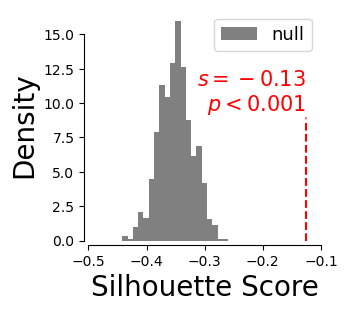

In [ ]:
output = np.histogram(finest_null_silscores, bins=20)
num_significant = sum(np.array(finest_null_silscores) > finest_type_silscore)
if num_significant > 0:
    pbound = num_significant/len(seeds)
else:
    pbound = 1/len(seeds)

    # pbound = output[0][-1]/len(seeds)
ys = np.arange(10)

fig, ax = plt.subplots(1,1, figsize=(3,3 ))

ax.hist(finest_null_silscores, color='grey', fill=True, density=True, bins=20, label='null')
plt.xlabel('Silhouette Score', size=20)
plt.ylabel('Density', size=20)
plt.plot([finest_type_silscore for y in ys], ys, 'r--')
addtext = f'$s={finest_type_silscore:.2f}$\n $p < {pbound}$'
plt.text(finest_type_silscore, ys[-1], addtext, horizontalalignment='right', \
         verticalalignment='bottom', color='red', size=15, 
         bbox=dict(boxstyle="round",
                   fc=(1, 1, 1, 0.5),
                   ec=(1,1,1,0)
                   ))
ax.set_xticks([-0.5, -0.4, -0.3, -0.2,  -0.1])

sns.despine(offset=3, trim=True)
plt.legend(prop={'size':13})
if save_things:
    plt.savefig(fw_fig_dir / f's_fw_silhouette_nulls.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(fw_fig_dir / f's_fw_silhouette_nulls.pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

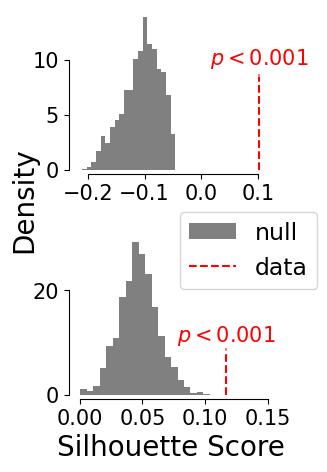

In [ ]:
fig = plt.figure(figsize=(3, 5))

gs = GridSpec(2, 1, figure=fig, height_ratios=[1, 1], hspace=0.4, )
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

for nulls, test_score, xranges, ax, title, in zip([coarse_null_silscores, layer_null_silscores], 
                                      [coarse_type_silscore, layer_test_silscore], 
                                      [[-.2, -.1, 0., .1], [ 0, 0.05, 0.1, 0.15]], 
                                      [ax1, ax2],
                                      ['Coarse animal type', 'Topological layer']):

    output = np.histogram(nulls, bins=20)
    num_significant = sum(np.array(nulls) > test_score)
    if num_significant > 0:
        pbound = num_significant/len(seeds)
    else:
        pbound = 1/len(seeds)

    ys = np.arange(10)
    ax.hist(nulls, color='grey', fill=True, density=True, bins=20, label='null')
    
    ax.plot([test_score for y in ys], ys, 'r--', label='data')
    # addtext = f'$s={test_score:.2f}$\n$p < {pbound}$'
    addtext = rf'$p < {pbound}$'

    ax.text(test_score, ys[-1], addtext, horizontalalignment='center', \
            verticalalignment='bottom', color='red', size=15, 
            bbox=dict(boxstyle="round",
                    fc=(1, 1, 1, 0.5),
                    ec=(1,1,1,0)
                    ))
    ax.set_xticks(xranges)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    sns.despine(offset=3, trim=True, ax=ax)
ax2.set_xlabel('Silhouette Score', size=20)
ax2.legend(prop={'size':17}, bbox_to_anchor=(0.9, 0.9), loc='center')
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=20)
plt.subplots_adjust(left=0.25, hspace=0.1)
if save_things:
    plt.savefig(fw_fig_dir / f'f1d_fw_silhouette_nulls.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(fw_fig_dir / 'f1d_fw_silhouette_nulls.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [26]:
# fig = plt.figure(figsize=(7, 3))

# gs = GridSpec(1, 2, figure=fig, width_ratios=[1, 1], wspace=0.4)
# ax1 = fig.add_subplot(gs[0, 0])
# ax2 = fig.add_subplot(gs[0, 1])

# for nulls, test_score, xranges, ax, title, label in zip([finest_null_silscores, layer_null_silscores], 
#                                       [finest_type_silscore, layer_test_silscore], 
#                                       [[-0.5, -0.4, -0.3, -0.2,  -0.1], [ 0, 0.05, 0.1, 0.15]], 
#                                       [ax1, ax2],
#                                       ['Finest animal type', 'Topological layer'], ['A', 'B']):
#     # ax.text(0, 1, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='bottom',  ha='right')

#     output = np.histogram(nulls, bins=20)
#     num_significant = sum(np.array(nulls) > test_score)
#     if num_significant > 0:
#         pbound = num_significant/len(seeds)
#     else:
#         pbound = 1/len(seeds)

#         # pbound = output[0][-1]/len(seeds)
#     ys = np.arange(10)
#     ax.set_title(title, size=15)
#     ax.hist(nulls, color='grey', fill=True, density=True, bins=20, label='null')
#     ax.set_xlabel('Silhouette Score', size=20)
#     ax.set_ylabel('Density', size=20)
#     ax.plot([test_score for y in ys], ys, 'r--')
#     addtext = f'$s={test_score:.2f}$\n$p < {pbound}$'
#     ax.text(test_score, ys[-1], addtext, horizontalalignment='right', \
#             verticalalignment='bottom', color='red', size=15, 
#             bbox=dict(boxstyle="round",
#                     fc=(1, 1, 1, 0.5),
#                     ec=(1,1,1,0)
#                     ))
#     ax.set_xticks(xranges)

#     sns.despine(offset=3, trim=True, ax=ax)
#     ax.legend(prop={'size':13})
# # save_things=False
# if save_things:
#     plt.savefig(f'{fw_save_dir}/s_fw_silhouette_nulls.png', dpi=300, bbox_inches='tight')
#     plt.savefig(f'{fw_save_dir}/s_fw_silhouette_nulls.pdf', dpi=300, bbox_inches='tight')
# plt.show()

# Recipe network:

In [27]:

rn_data_dir = cwd.parent / 'data' / 'recipe'
rn_processed_dir = rn_data_dir / 'processed'

rn_fig_dir = cwd.parent / 'figures' / 'recipe'


In [28]:
rn_df, meta_df = prep_recipe_data()
cuisine_list = meta_df.cuisine.dropna().unique()
recipe_list = rn_df.r_id.dropna().unique()

ingredient_list = list(set(rn_df.ingredient.dropna().unique()) - {''})
rn_df = rn_df[rn_df['ingredient'].isin(ingredient_list)].reset_index(drop=True)

In [29]:
cs_i_vectors = pd.read_parquet( rn_processed_dir / 'cs_i_vectors.parquet')
is_c_vectors = pd.read_parquet(rn_processed_dir / 'is_c_vectors.parquet')

## ingredient type evaluation

In [30]:
metric = 'euclidean'
method = 'ward'
ind_to_id = np.array(ingredient_list)

Z = linkage(cs_i_vectors.loc[ingredient_list, cuisine_list], metric=metric, method=method) ####### linkage


In [31]:
ing_categories = pd.read_csv(rn_data_dir / 'foodtype_categorised.csv')
# ing_categories = ing_categories.iloc[:, :2]
# remove = set(ing_categories.Ingredient) - set(rn_df.ingredient.unique()) 
# ing_categories = ing_categories[~ing_categories.Ingredient.isin(remove)]
# ing_categories.Category = ing_categories.Category.str.lower()
# ing_categories.to_csv('../data/recipe/foodtype_categorised_2.csv', index=False)

In [32]:
ingredient_type_dict = ing_categories.set_index('Ingredient').Category.to_dict()
sil_labels = [ingredient_type_dict.get(i) for i in ingredient_list]

In [33]:
sample_sils = silhouette_samples(cs_i_vectors.loc[ingredient_list], \
                                 metric=metric, labels=sil_labels)

In [34]:
sorted(list(zip(ingredient_list, sample_sils)), key=lambda x: x[1])

[('oak', np.float64(-0.6025143814273886)),
 ('fennel', np.float64(-0.5509401978682218)),
 ('seed', np.float64(-0.5435673587217168)),
 ('pine', np.float64(-0.5382199649983636)),
 ('almond', np.float64(-0.506246090276574)),
 ('milk', np.float64(-0.504969233091754)),
 ('beef', np.float64(-0.48598639850868663)),
 ('meat', np.float64(-0.4843591819565179)),
 ('chicken', np.float64(-0.48285983578254926)),
 ('cream', np.float64(-0.4676527267854255)),
 ('cheese', np.float64(-0.4597173465807396)),
 ('chicory', np.float64(-0.44846135609046806)),
 ('cream_cheese', np.float64(-0.4409054435232835)),
 ('pork', np.float64(-0.4327282515010951)),
 ('juniper_berry', np.float64(-0.4311257842407916)),
 ('pecan', np.float64(-0.4288448162943916)),
 ('shrimp', np.float64(-0.41668172910636125)),
 ('bread', np.float64(-0.413449499167338)),
 ('orange_flower', np.float64(-0.40729277803761477)),
 ('rose', np.float64(-0.40723783031817096)),
 ('lamb', np.float64(-0.4029580673887963)),
 ('orange', np.float64(-0.39930

In [35]:
i_sil_score = np.mean(sample_sils)

print('Ingredient type silhouette score:', i_sil_score)

Ingredient type silhouette score: -0.1989453943184878


## Cuisine type evaluation:

In [36]:
metric = 'euclidean'
method = 'ward'
ind_to_id = np.array(cuisine_list)
Z = linkage(is_c_vectors.loc[ind_to_id, ingredient_list], metric=metric, method=method) ####### linkage


In [37]:
# ind_to_cuisine_dict = {'Vietnamese': 'SE_Asia',
#  'Indian': 'S_Asia_Middle_East',
#  'French': 'N_Europe',
#  'Jewish': 'N_Europe',
#  'Spanish_Portuguese': 'S_Europe',
#  'Central_SouthAmerican': 'South_America',
#  'Cajun_Creole': 'North_America',
#  'Thai': 'SE_Asia',
#  'Scandinavian': 'N_Europe',
#  'Greek': 'S_Europe',
#  'American': 'North_America',
#  'African': 'Africa',
#  'MiddleEastern': 'S_Asia_Middle_East',
#  'EasternEuropean_Russian': 'N_Europe',
#  'Italian': 'S_Europe',
#  'Irish': 'N_Europe',
#  'Mexican': 'North_America',
#  'Chinese': 'E_Asia',
#  'German': 'N_Europe',
#  'Mediterranean': 'S_Europe',
#  'Japanese': 'E_Asia',
#  'Moroccan': 'Africa',
#  'Southern_SoulFood': 'North_America',
#  'English_Scottish': 'N_Europe',
#  'Asian': 'E_Asia',
#  'Southwestern': 'North_America'}


In [38]:
# pd.DataFrame.from_dict(ind_to_cuisine_dict, orient='index', columns=['geo_label']).reset_index().rename(columns={'index': 'cuisine_type'}).to_csv('../data/recipe/cuisine_geo_labels.csv', index=False)

In [39]:
ind_to_cuisine_dict = pd.read_csv('../data/recipe/cuisine_geo_labels.csv').set_index('cuisine_type').geo_label.to_dict()

In [40]:
ind_to_cuisinetype = [ind_to_cuisine_dict.get(i) for i in ind_to_id]
sil_labels = ind_to_cuisinetype

In [41]:
sample_sils = silhouette_samples(is_c_vectors.loc[ind_to_id, ingredient_list], \
                                 metric=metric, labels=sil_labels)

In [42]:
sorted(list(zip(ind_to_id, sample_sils)), key=lambda x:x[1])

[('Mexican', np.float64(-0.6524540769332355)),
 ('MiddleEastern', np.float64(-0.5258376861966063)),
 ('Southwestern', np.float64(-0.4389084132975546)),
 ('American', np.float64(-0.2238299487281411)),
 ('Indian', np.float64(-0.15684617008651605)),
 ('Southern_SoulFood', np.float64(-0.1240938104626541)),
 ('Cajun_Creole', np.float64(-0.04496057795260941)),
 ('Central_SouthAmerican', np.float64(0.0)),
 ('Jewish', np.float64(0.1019928736185198)),
 ('French', np.float64(0.14031026330163157)),
 ('German', np.float64(0.18934436568575283)),
 ('Spanish_Portuguese', np.float64(0.20949022629636993)),
 ('Irish', np.float64(0.24167164320012158)),
 ('Scandinavian', np.float64(0.2655248729559764)),
 ('African', np.float64(0.2792694058683339)),
 ('EasternEuropean_Russian', np.float64(0.29059005809602667)),
 ('Asian', np.float64(0.29099028603459604)),
 ('English_Scottish', np.float64(0.3057195563519841)),
 ('Italian', np.float64(0.3771696214517936)),
 ('Greek', np.float64(0.37817912996912056)),
 ('Medi

In [43]:
c_sil_score = np.mean(sample_sils)
print('Cuisine type silhouette score:', c_sil_score)

Cuisine type silhouette score: 0.13238022718237621


## Null models:

In [44]:
# initialise the necessary matrices for the recipe-ingredient and recipe-cuisine networks

a_RC_coo, recipe_row, cuisine_col = bipartite_cooarray( \
    df=meta_df.sort_values(['r_id', 'cuisine']), \
    row_col=['r_id', 'cuisine'], \
    weight=False, \
    row_order=list(recipe_list), \
    col_order=list(cuisine_list))

a_RI_coo, recipe_row, ingredient_col = bipartite_cooarray( \
        df=rn_df.sort_values(['r_id', 'ingredient']), \
        row_col=['r_id', 'ingredient'], \
        weight=False, \
        row_order=list(recipe_list), \
        col_order=list(ingredient_list))


In [46]:
# randomised cuisine nulls:
seeds= np.arange(1000)

# typelist = meta_df_bpt.type.unique()
continent_labels = [ind_to_cuisine_dict.get(i) for i in cuisine_list]
ingredient_labels = [ingredient_type_dict.get(i) for i in ingredient_list]

RCshuff_is_c_sil_means = []
RCshuff_cs_i_sil_means = []

for seed in seeds:
    output = rn_RCshuff_wrapper(
        seed=seed, \
        a_RI_coo=a_RI_coo, \
        meta_df=meta_df, \
        recipe_list=recipe_list, \
        cuisine_list=cuisine_list, \
        ingredient_col=ingredient_col)
    
    norm_is_c_vec_df_RCshuff, cnorm_cs_i_bpt_df_RCshuff = output

    # both identity preserving nulls:
    RC_shuff_is_c_null_sils = silhouette_samples(norm_is_c_vec_df_RCshuff.loc[cuisine_list, ingredient_list], \
                                    metric=metric, labels=continent_labels)
    RC_shuff_cs_i_null_sils = silhouette_samples(cnorm_cs_i_bpt_df_RCshuff.loc[ingredient_list], \
                                 metric=metric, labels=ingredient_labels)

    RCshuff_is_c_sil_means.append(np.mean(RC_shuff_is_c_null_sils))
    RCshuff_cs_i_sil_means.append(np.mean(RC_shuff_cs_i_null_sils))

# ~40s

In [47]:
# randomised recipe nulls:
seeds = np.arange(1000)
continent_labels = [ind_to_cuisine_dict.get(i) for i in cuisine_list]
ingredient_labels = [ingredient_type_dict.get(i) for i in ingredient_list]

RIshuff_is_c_sil_means = []
RIshuff_cs_i_sil_means = []

for seed in seeds:
    
    output = rn_RIshuff_wrapper(
        seed=seed, \
        a_RC_coo=a_RC_coo, \
        rn_df=rn_df, \
        recipe_list=recipe_list, \
        cuisine_list=cuisine_list, \
        ingredient_list=ingredient_list)
    norm_is_c_vec_df_RIshuff, cnorm_cs_i_bpt_df_RIshuff = output # an instance of a shuffled vectors

    # calculate the silhouette scores for the shuffled vectors:
    RI_shuff_is_c_null_sils = silhouette_samples(norm_is_c_vec_df_RIshuff.loc[cuisine_list, ingredient_list], \
                                    metric=metric, labels=continent_labels)
    RI_shuff_cs_i_null_sils = silhouette_samples(cnorm_cs_i_bpt_df_RIshuff.loc[ingredient_list], \
                                 metric=metric, labels=ingredient_labels)

    RIshuff_is_c_sil_means.append(np.mean(RI_shuff_is_c_null_sils))
    RIshuff_cs_i_sil_means.append(np.mean(RI_shuff_cs_i_null_sils))

# ~2min 35s

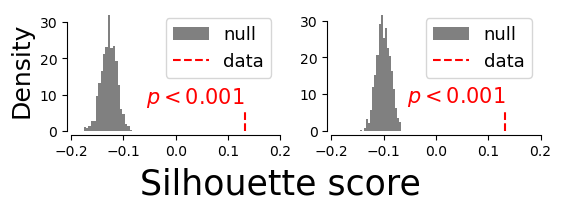

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(5.5,2), layout='constrained',)

pbound = 1/len(seeds)

test_x =c_sil_score
ys = np.arange(7)
ax[0].hist(RCshuff_is_c_sil_means, color='grey', fill=True, density=True, bins=20, label='null')
ax[0].plot([test_x for y in ys], ys, 'r--',  label='data')
addtext = rf'$p < {pbound}$'
# addtext = f'$s={test_x:.2f}$\n$p < {pbound}$'

ax[0].text(test_x, ys[-1], addtext, horizontalalignment='right', verticalalignment='bottom', color='red', size=15)
ax[0].legend(prop={'size':13})
ax[0].set_xlim(-0.2, 0.2)
ax[0].set_ylabel('Density', size=18,)
sns.despine(offset=3, trim=True, ax=ax[0])


test_x =c_sil_score
ys = np.arange(7)
ax[1].hist(RIshuff_is_c_sil_means, color='grey', fill=True, density=True, bins=20, label='null') # #5A7CA8
ax[1].plot([test_x for y in ys], ys, 'r--',  label='data')
addtext = rf'$p < {pbound}$'
# addtext = f'$s={test_x:.2f}$\n$p < {pbound}$'

ax[1].text(test_x, ys[-1], addtext, horizontalalignment='right', verticalalignment='bottom', color='red', size=15)
ax[1].legend(prop={'size':13})
ax[1].set_xlim(-0.2, 0.2)
sns.despine(offset=3, trim=True, ax=ax[1])



# fig.supylabel('Density', size=18)
fig.supxlabel('Silhouette score', size=25)
# plt.tight_layout()
# save_things=False
if save_things:
    plt.savefig(rn_fig_dir / f'f3b_recipe_silhouette_nulls.png', dpi=300, bbox_inches='tight',  transparent=True)
    plt.savefig(rn_fig_dir / f'f3b_recipe_silhouette_nulls.pdf', dpi=300, bbox_inches='tight', transparent=True)  
plt.show()

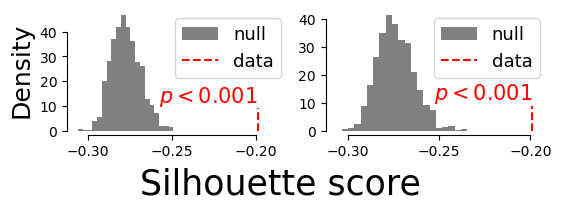

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(5.5,2), layout='constrained',)

pbound = 1/len(seeds)



output = np.histogram(RCshuff_cs_i_sil_means, bins=20)
test_x =i_sil_score
ys = np.arange(10) 
ax[0].hist(RCshuff_cs_i_sil_means, color='grey', fill=True, density=True, bins=20, label='null') # #F88E86
ax[0].plot([test_x for y in ys], ys, 'r--',  label='data')
addtext = rf'$p < {pbound}$'
# addtext = f'$s={test_x:.2f}$\n$p < {pbound}$'
ax[0].set_ylabel('Density', size=18,)

ax[0].text(test_x, ys[-1], addtext, horizontalalignment='right', verticalalignment='bottom', color='red', size=15)
ax[0].legend(prop={'size':13})
ax[0].set_xlim(-0.31, -0.18)
ax[0].set_xticks([-0.3, -0.25, -0.2])
sns.despine(offset=3, trim=True, ax=ax[0])


output = np.histogram(RIshuff_cs_i_sil_means, bins=20)
test_x =i_sil_score
ys = np.arange(10)
ax[1].hist(RIshuff_cs_i_sil_means, color='grey', fill=True, density=True, bins=20, label='null')
ax[1].plot([test_x for y in ys], ys, 'r--',  label='data')
addtext = rf'$p < {pbound}$'
# addtext = f'$s={test_x:.2f}$\n$p < {pbound}$'

ax[1].text(test_x, ys[-1], addtext, horizontalalignment='right', verticalalignment='bottom', color='red', size=15,)
ax[1].legend(prop={'size':13})
ax[1].set_xlim(-0.31, -0.19)
ax[1].set_xticks([-0.3, -0.25, -0.2])

sns.despine(offset=3, trim=True, ax=ax[1])
fig.supxlabel('Silhouette score', size=25)
if save_things:
    plt.savefig(rn_fig_dir / f'f2d_recipe_silhouette_nulls.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(rn_fig_dir / f'f2d_recipe_silhouette_nulls.pdf', dpi=300, bbox_inches='tight', transparent=True)  
plt.show()